# loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pathlib
import darts
from darts import TimeSeries
import matplotlib.pyplot as plt
from tqdm import tqdm
from darts.dataprocessing.transformers.scaler import Scaler

# Helping Functions


In [2]:
import numpy as np


def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for easier calculations
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate individual metrics
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    mse = np.mean((predicted - actual) ** 2)

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape, "MSE": mse}

    return metrics

# Data Reading 😶

In [3]:
fileName = "highcorrelated_features"
df = pd.read_csv(f"../ProcessedData/{fileName}/{fileName}.csv")
df.head()

,date,net_sales_total,net_order_entry_total,mitarbeiter_vertrieb,mitarbeiter_service,mitarbeiter_total
0,2014-01-31,9914.85,13197.85,94,178,272
1,2014-02-28,8793.66,11632.08,96,178,274
2,2014-03-31,12689.12,14404.37,97,179,276
3,2014-04-30,12420.60,11512.26,97,180,277
4,2014-05-31,11825.02,11875.16,99,178,277


In [4]:
df = df[["date", "net_sales_total"]]
df = df.drop_duplicates()
df.head()

,date,net_sales_total
0,2014-01-31,9914.85
1,2014-02-28,8793.66
2,2014-03-31,12689.12
3,2014-04-30,12420.60
4,2014-05-31,11825.02


## Spliting Data into Training & Testing Data

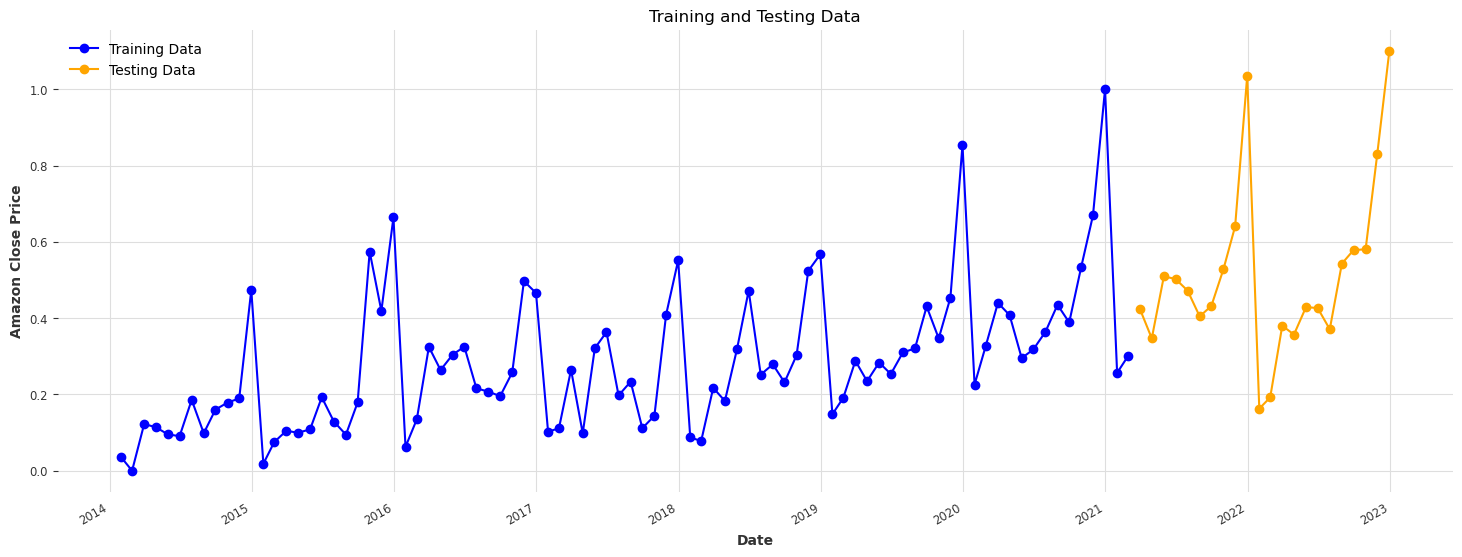

In [5]:
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing daily data
series = TimeSeries.from_dataframe(
    df, "date", "net_sales_total", freq="1M", fill_missing_dates=True, fillna_value=0
)


split_point = 0.80

train_series, test_series = series.split_after(split_point)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train_series)
test_transformed = transformer.transform(test_series)
series_transformed = transformer.transform(series)


# Set the figure size and style
plt.figure(figsize=(18, 6))
# Plot the training and testing data
train_transformed.plot(label="Training Data", color="blue", linewidth=1.5, marker="o")
test_transformed.plot(label="Testing Data", color="orange", linewidth=1.5, marker="o")

# Add title and labels
plt.title("Training and Testing Data")
plt.xlabel("Date")
plt.ylabel("Amazon Close Price")

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

# LSTM-RNN


In [26]:
from darts.models.forecasting.rnn_model import RNNModel


rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=40,
    dropout=0,
    batch_size=8,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="StoreNBR",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=5,
    force_reset=True,
    save_checkpoints=True,
)
rnn_model.fit(train_transformed)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 6.9 K 
4 | V             | Linear           | 41    
---------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 104.32it/s, v_num=logs, train_loss=0.00932]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 9/9 [00:00<00:00, 95.25it/s, v_num=logs, train_loss=0.00932] 


RNNModel(model=LSTM, hidden_dim=40, n_rnn_layers=1, dropout=0, training_length=20, batch_size=8, n_epochs=300, optimizer_kwargs={'lr': 0.001}, model_name=StoreNBR, log_tensorboard=True, random_state=42, input_chunk_length=5, force_reset=True, save_checkpoints=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.07it/s]


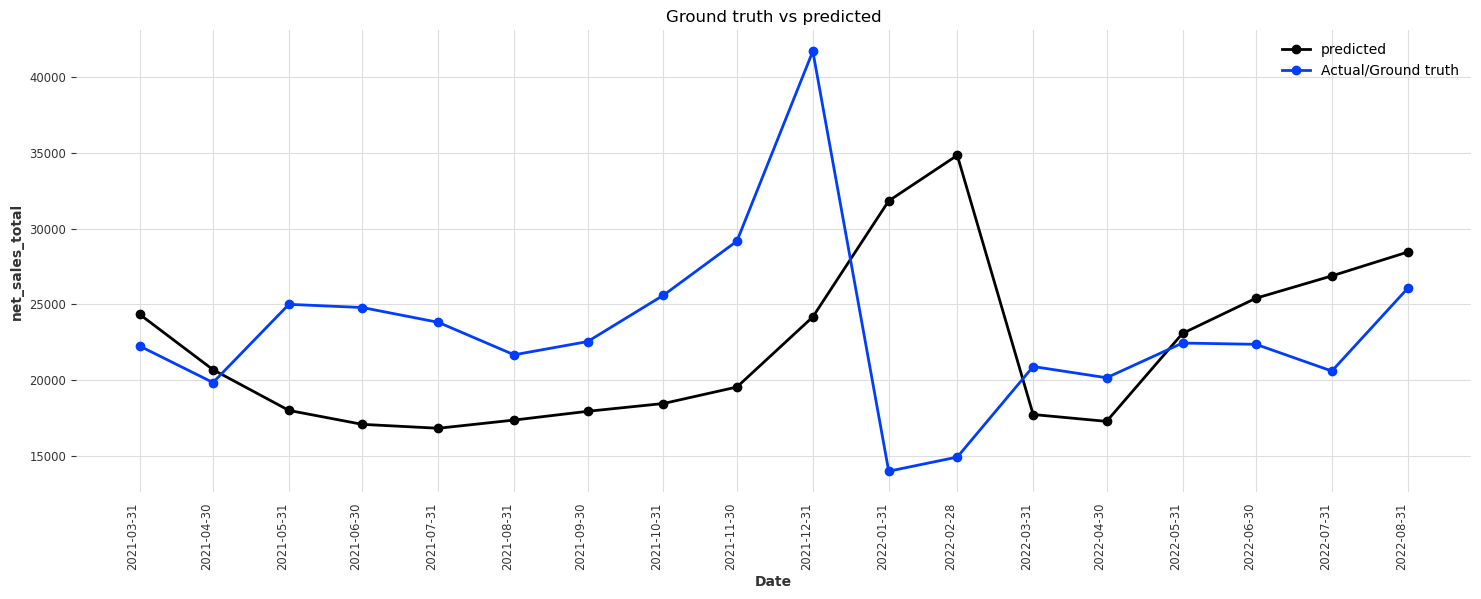

In [29]:
horizan = 18
test_series_ = test_transformed[0:horizan]
plt.figure(figsize=(18, 6))

forcast_rnn = rnn_model.predict(horizan)
forecast = transformer.inverse_transform(forcast_rnn)
ground_truth = transformer.inverse_transform(test_series_)

forecast.plot(marker="o", label="predicted")
ground_truth.plot(marker="o", label="Actual/Ground truth")
# Add title and labels
plt.title("Ground truth vs predicted")
plt.xlabel("Date")
plt.ylabel("net_sales_total")
plt.xticks(
    forcast_rnn.time_index, forcast_rnn.time_index.strftime("%Y-%m-%d"), rotation=90
)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
# plt.savefig(
#     f"../ProcessedData/Results/ARIMA/highcorrelated_features/ARIMA_Plots/utilized_all.png"
# )
plt.show()

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


# Function to predict and evaluate
def predict_and_evaluate(
    window_size,
    prediction_horizon,
    slide_step,
    test_series,
    model,
    result_plot_path,
    transformer,
):
    num_predictions = len(test_series) - window_size - prediction_horizon + 1

    meta_information_evaluation = {
        "Iterations": [],
        "MAE": [],
        "RMSE": [],
        "MAPE": [],
        "MSE": [],
        "input_window_size": [],
        "horizon": [],
        "stride": [],
    }

    try:
        for i in tqdm(range(0, num_predictions, slide_step)):
            input_window = test_series[i : i + window_size]
            ground_truth = test_series[
                i + window_size : i + window_size + prediction_horizon
            ]
            forecast = model.predict(n=prediction_horizon, series=input_window)

            input_window = transformer.inverse_transform(input_window)
            ground_truth = transformer.inverse_transform(ground_truth)
            forecast = transformer.inverse_transform(forecast)
            # print(ground_truth)

            # print('1:Actual:', ground_truth.values().flatten().tolist())
            # print('2:Predicted:', predicted.values().flatten().tolist())
            # print('3:Input:',input_window.values().flatten().tolist())

            actual = ground_truth.values().flatten().tolist()
            predicted = forecast.values().flatten().tolist()

            metrics = calculate_metrics(actual, predicted)

            meta_information_evaluation["Iterations"].append(i)
            meta_information_evaluation["MAE"].append(metrics["MAE"])
            meta_information_evaluation["RMSE"].append(metrics["RMSE"])
            meta_information_evaluation["MAPE"].append(metrics["MAPE"])
            meta_information_evaluation["MSE"].append(metrics["MSE"])
            meta_information_evaluation["input_window_size"].append(window_size)
            meta_information_evaluation["horizon"].append(prediction_horizon)
            meta_information_evaluation["stride"].append(slide_step)

            bypass_information = {
                "slide_step": slide_step,
                "window_size": window_size,
                "horizon": prediction_horizon,
            }
            create_plots(
                input_window,
                forecast,
                ground_truth,
                result_plot_path,
                bypass_information,
            )

        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df

    except Exception as e:
        print("Error Occurred in fuction predict_and_evaluate():", e)
        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df


# Function to create plots
def create_plots(
    input_window, forecast, ground_truth, result_plot_path, bypass_information
):
    plt.figure(figsize=(30, 6))
    input_window.plot(label="Input Data", marker="o")
    forecast.plot(label="Predicted", marker="o")
    ground_truth.plot(label="Ground Truth", marker="o")

    combined_time_index = input_window.time_index.append(forecast.time_index).append(
        ground_truth.time_index
    )
    starting_date_of_input_data = input_window.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_input_data = input_window.time_index[-1].strftime("%Y-%m-%d")
    starting_date_predicted = forecast.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_predicted = forecast.time_index[-1].strftime("%Y-%m-%d")

    plt.xticks(
        combined_time_index, combined_time_index.strftime("%Y-%m-%d"), rotation=90
    )
    plt.title(
        f"Results of Input Data from {starting_date_of_input_data} to {ending_date_of_input_data} & Evaluation on from {starting_date_predicted} to {ending_date_of_predicted}",
        fontsize=16,
    )
    plt.ylabel("net_sales_total", fontsize=14)
    plt.xlabel("Dates", fontsize=14)
    plt.legend()

    plot_filename = f"{result_plot_path}/{bypass_information['window_size']}_{bypass_information['horizon']}_{bypass_information['slide_step']}.png"
    plt.savefig(plot_filename)
    plt.close()
    # plt.show()

# Model Evaluation

In [33]:
def model_evaluation(model_name, model_object, test_series, transformer, FileName):
    result_path = f"../ProcessedData/Results/{model_name}/{FileName}"
    result_plot_path = (
        f"../ProcessedData/Results/{model_name}/{FileName}/{model_name}_Plots"
    )
    os.makedirs(result_path, exist_ok=True)
    os.makedirs(result_plot_path, exist_ok=True)

    # Set your parameters
    # Set your parameters
    window_sizes = [6, 12, 18]
    prediction_horizons = [6, 12, 18]
    slide_steps = [2, 5, 8]

    test_series = test_series
    model = model_object

    for window_size in window_sizes:
        for prediction_horizon in prediction_horizons:
            for slide_step in slide_steps:
                print(
                    f"Iteration : Window size : {window_size} Horizan: {prediction_horizon}, Stride : {slide_step}"
                )
                evaluation_df = predict_and_evaluate(
                    window_size,
                    prediction_horizon,
                    slide_step,
                    test_series,
                    model,
                    result_plot_path,
                    transformer,
                )
                evaluation_df.to_csv(
                    f"{result_path}/window_size_{window_size}_horizon_{prediction_horizon}_stride_{slide_step}.csv",
                    index=False,
                )

                print(
                    f"Window_size_{window_size}_prediction_horizon_{prediction_horizon}_slide_step_{slide_step} - Evaluation completed."
                )
        #         break
        #     break
        # break

## RNN-LSTM

In [34]:
model_name = "RNN_LSTM"
FileName = fileName
model_object = rnn_model
test_series = test_transformed
model_evaluation(model_name, model_object, test_series, transformer, FileName)

Iteration : Window size : 6 Horizan: 6, Stride : 2


  0%|          | 0/6 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.17it/s]


 17%|█▋        | 1/6 [00:00<00:01,  2.57it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.58it/s]


 33%|███▎      | 2/6 [00:00<00:01,  2.30it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.72it/s]


 50%|█████     | 3/6 [00:01<00:01,  2.35it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.17it/s]


 67%|██████▋   | 4/6 [00:01<00:00,  2.42it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.12it/s]


 83%|████████▎ | 5/6 [00:02<00:00,  2.43it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.31it/s]


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Window_size_6_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 6, Stride : 5


  0%|          | 0/3 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.49it/s]


 33%|███▎      | 1/3 [00:00<00:00,  2.77it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.21it/s]


 67%|██████▋   | 2/3 [00:00<00:00,  2.50it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.81it/s]


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Window_size_6_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 6, Stride : 8


  0%|          | 0/2 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s] 


 50%|█████     | 1/2 [00:00<00:00,  1.97it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.07it/s]


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Window_size_6_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 2


  0%|          | 0/3 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.54it/s] 


 33%|███▎      | 1/3 [00:00<00:01,  1.93it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.57it/s]


 67%|██████▋   | 2/3 [00:01<00:00,  1.89it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.73it/s] 


100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


Window_size_6_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 5


  0%|          | 0/1 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.23it/s]


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Window_size_6_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 8


  0%|          | 0/1 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.28it/s]


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Window_size_6_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 8


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 2


  0%|          | 0/3 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.96it/s]


 33%|███▎      | 1/3 [00:00<00:01,  1.43it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.48it/s]


 67%|██████▋   | 2/3 [00:01<00:00,  1.68it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.29it/s]


100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Window_size_12_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 5


  0%|          | 0/1 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.16it/s]


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Window_size_12_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 8


  0%|          | 0/1 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.14it/s]


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Window_size_12_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 2


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 5


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 8


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 8


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 8


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 8


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 8


0it [00:00, ?it/s]

Window_size_18_prediction_horizon_18_slide_step_8 - Evaluation completed.


# Evaluate Metrics

In [35]:
import pandas as pd
import glob


def aggregate_evaluation_results(file_pattern):
    eval_dict = {
        "window_size": [],
        "horizan": [],
        "stride": [],
        "AVG_MAE": [],
        "AVG_MSE": [],
        "AVG_RMSE": [],
        "AVG_MAPE": [],
    }

    paths = glob.glob(file_pattern)

    for path in paths:
        window_size = path.split("/")[-1].split("_")[2]
        horizan = path.split("/")[-1].split("_")[4]
        stride = path.split("/")[-1].split("_")[6].split(".")[0]

        df = pd.read_csv(path)
        eval_dict["window_size"].append(window_size)
        eval_dict["horizan"].append(horizan)
        eval_dict["stride"].append(stride)

        eval_dict["AVG_MAE"].append(df["MAE"].mean())
        eval_dict["AVG_MSE"].append(df["MSE"].mean())
        eval_dict["AVG_RMSE"].append(df["RMSE"].mean())
        eval_dict["AVG_MAPE"].append(df["MAPE"].mean())

    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.dropna()
    eval_df.sort_values(
        ["window_size", "horizan", "stride"], inplace=True, ascending=True
    )

    return eval_df


# Example usage
file_pattern = f"../ProcessedData/Results/RNN_LSTM/{fileName}/*.csv"
result_df = aggregate_evaluation_results(file_pattern)
# result_df = result_df[
#     ["window_size", "horizan", "stride", "AVG_MAE", "AVG_MSE", "AVG_RMSE"]
# ]
result_df

,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
23,12,6,2,7605.116350,9.603634e+07,9156.200399,26.945446
13,12,6,5,4959.350013,3.421757e+07,5849.578829,21.557967
0,12,6,8,4959.350013,3.421757e+07,5849.578829,21.557967
19,6,12,2,4870.783482,4.708544e+07,6710.157538,20.896707
9,6,12,5,5830.216976,6.663281e+07,8162.892221,22.340399
22,6,12,8,5830.216976,6.663281e+07,8162.892221,22.340399
17,6,6,2,7070.434633,8.798581e+07,8967.380756,27.755264
16,6,6,5,7419.789852,1.071750e+08,9578.695579,26.151918
5,6,6,8,6795.454695,8.215838e+07,8965.424691,24.796019


In [36]:
for name, group in result_df.groupby(["window_size", "horizan"]):
    print(name)
    display(group)

('12', '6')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
23,12,6,2,7605.116350,9.603634e+07,9156.200399,26.945446
13,12,6,5,4959.350013,3.421757e+07,5849.578829,21.557967
0,12,6,8,4959.350013,3.421757e+07,5849.578829,21.557967


('6', '12')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
19,6,12,2,4870.783482,4.708544e+07,6710.157538,20.896707
9,6,12,5,5830.216976,6.663281e+07,8162.892221,22.340399
22,6,12,8,5830.216976,6.663281e+07,8162.892221,22.340399


('6', '6')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
17,6,6,2,7070.434633,8.798581e+07,8967.380756,27.755264
16,6,6,5,7419.789852,1.071750e+08,9578.695579,26.151918
5,6,6,8,6795.454695,8.215838e+07,8965.424691,24.796019
